In [113]:
# Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [114]:
lightgbm.__version__

'3.3.2'

In [115]:
df = pd.read_csv("data/train.csv")
df["ID"] = df["filename"].str.split(".",expand=True)[0]
df=df.drop("filename",axis=1)
ss = pd.read_csv("data/SampleSubmission.csv")
tdf = pd.read_csv("data/test.csv")

In [116]:
df[df.ID=='B0001-12_1']

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID
0,B0001-12,2023-02-09 01:00:00,99.519744,29.417,0.636289,10.126880,8.640631,12.523579,32.209893,0.0,0.000000,B0001-12_1
1,B0001-12,2023-02-09 02:00:00,99.216125,15.894,0.711312,9.145678,8.749684,10.642076,37.591142,0.0,0.000000,B0001-12_1
2,B0001-12,2023-02-09 03:00:00,99.960815,27.401,0.689756,10.123859,9.282525,14.116277,24.761631,0.0,0.000000,B0001-12_1
3,B0001-12,2023-02-09 04:00:00,100.000000,19.320,0.675434,9.721365,9.465269,14.872375,42.208165,0.0,0.000000,B0001-12_1
4,B0001-12,2023-02-09 05:00:00,99.953315,18.154,0.646022,10.229611,9.270378,15.106532,40.002877,0.0,0.000000,B0001-12_1
...,...,...,...,...,...,...,...,...,...,...,...,...
272,B0001-12,2023-02-20 09:00:00,100.000000,16.023,0.754630,9.543981,8.789539,13.537159,38.502784,0.0,0.000000,B0001-12_1
273,B0001-12,2023-02-20 10:00:00,100.000000,45.113,0.759430,10.249399,8.600942,12.360695,24.524838,0.0,0.000000,B0001-12_1
274,B0001-12,2023-02-20 11:00:00,100.000000,45.419,0.811247,10.261306,8.565688,12.344837,21.864610,0.0,0.000000,B0001-12_1
275,B0001-12,2023-02-20 12:00:00,100.000000,29.382,0.763943,10.336147,8.241281,11.089316,23.253083,0.0,0.000000,B0001-12_1


In [117]:
df["ID"].nunique()

7256

In [118]:
df["endTime"].min(),df["endTime"].max()

('2023-02-09 01:00:00', '2023-03-02 00:00:00')

In [119]:
tdf[tdf.ID=="B0017-25_24"]

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,ID
0,B0017-25,2023-02-20 06:00:00,99.714558,8.678,3.715410,7.653169,5.964988,5.403557,6.815789,0.0,0.000000,B0017-25_24
1,B0017-25,2023-02-20 07:00:00,99.927484,24.264,3.145402,10.015796,6.141206,6.544645,6.777114,0.0,0.000000,B0017-25_24
2,B0017-25,2023-02-20 08:00:00,99.357688,84.004,2.923368,14.209819,5.582824,5.667775,1.175289,0.0,0.000000,B0017-25_24
3,B0017-25,2023-02-20 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301.0,0.654162,B0017-25_24


In [120]:
num_cols=["access_success_rate","resource_utilition_rate","TA","bler","cqi","mcs"]

In [121]:
df["NE ID ID COUNT"] = df.groupby("NE ID")["ID"].transform("nunique")
tdf["NE ID ID COUNT"] = tdf.groupby("NE ID")["ID"].transform("nunique")

In [122]:
cat_cols=["A","B","C","ID","NE ID"]

In [123]:
# Extract Time Features
for x in [df,tdf]:
    x[["A","C"]] = x.ID.str.split("_",expand=True)
    x[["A","B"]] = x.A.str.split("-",expand=True)
    x["A"] = x.A.str.split("B",expand=True)[1]
    for col in ["A","B","C"]:
        x[col] = x[col].astype("int")
    x.endTime=pd.to_datetime(x.endTime)
    x["month"] = x.endTime.dt.month
    x["day"] = x.endTime.dt.day
    x["dow"] = x.endTime.dt.day_of_week.astype("int")
    x["hour"] = x.endTime.dt.hour
    x["ts"] = x.endTime.values.astype("int")
    x["ts"] = x.ts/1000000000

In [124]:
df=df.reset_index()

In [125]:
tdf=tdf.reset_index()

In [126]:
df["test"]=0
tdf["test"]=1

In [127]:
df=df.append(tdf[df.columns])

In [128]:
df = df.sort_values(["ID","endTime"])

In [129]:
df["Count_feature_1"] = df.groupby(["ID"])["ID"].transform("count")
df["Count_feature_2"] = df.groupby(["NE ID"])["NE ID"].transform("count")
df["Count_feature_3"] = df.groupby(["A"])["A"].transform("count")
df["Count_feature_4"] = df.groupby(["B"])["B"].transform("count")
df["NE suffix count encoded"] = df.groupby(["C"])["C"].transform("count")

In [130]:
df["NE_Index"] = df.groupby(["ID"])["index"].transform("min")
df["NE_Index"] = df["index"]-df["NE_Index"]  

In [131]:
df["fault_duration X relation"]=df.fault_duration*df.relation
df["fault_duration X relation present hour"]=df.groupby(["ID"])["fault_duration X relation"].shift(-1)

In [132]:
df["next_data_rate"] = df.groupby(["ID"])["data_rate"].shift(-1)
df["fault_duration present hour"] = df.groupby(["ID"])["fault_duration"].shift(-1)
df["relation present hour"] = df.groupby(["ID"])["relation"].shift(-1)

In [133]:
# Extract Lag Features
for i in range(1,43,1):
    for col in ["data_rate"]:
        df[f"last_{col}_{i}"] = df.groupby(["ID"])[col].shift(i)
        df[f"last_{col}_vs_{i}"] = (df[col]+0.1)/(df[f"last_{col}_{i}"]+0.1)
        if i > 1:
            df[f"last_{col}_{i}_vs_{i-1}"] = (df[f"last_{col}_{i}"]+0.1)/(df[f"last_{col}_{i-1}"]+0.1)

<ipython-input-133-68d9d00731d2>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"last_{col}_{i}"] = df.groupby(["ID"])[col].shift(i)
<ipython-input-133-68d9d00731d2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"last_{col}_vs_{i}"] = (df[col]+0.1)/(df[f"last_{col}_{i}"]+0.1)
<ipython-input-133-68d9d00731d2>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

<ipython-input-133-68d9d00731d2>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"last_{col}_{i}"] = df.groupby(["ID"])[col].shift(i)
<ipython-input-133-68d9d00731d2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"last_{col}_vs_{i}"] = (df[col]+0.1)/(df[f"last_{col}_{i}"]+0.1)
<ipython-input-133-68d9d00731d2>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

In [134]:
df = df.rename({
    "A":"NE_PREFIX","C":"NE_SUFFIX","fault_duration":"fault_duration past hour","relation":"relation past hour"
    ,"access_success_rate":"access_success_rate past hour","resource_utilition_rate":"resource_utilition_rate past hour"
},axis=1)
tdf = df[df["test"]==1]
tdf = tdf[tdf["fault_duration present hour"]>0]
df = df[df["test"]==0]


In [135]:
df["class"] = (df["data_rate"]>df["next_data_rate"]).astype("int")
df["class"].describe()

count    908922.000000
mean          0.483683
std           0.499734
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: class, dtype: float64

In [136]:
target = "next_data_rate"

In [137]:
drop_cols = [
    "NE ID","endTime","ID",target, "class","test"
]
cols = df.drop(drop_cols,axis=1).columns


In [138]:
df["count_available_features"] = df[cols].count(axis=1)
tdf["count_available_features"] = tdf[cols].count(axis=1)

In [139]:
select_cols = tdf[tdf.count_available_features==31]
select_cols = list(select_cols[cols].dropna(axis=1).columns)
len(select_cols)

31

- # Model 1 - Train With All Features

In [140]:
model1 = LGBMClassifier(n_estimators=1000)
tdf["class"]=model1.fit(df[cols],df["class"]).predict_proba(tdf[cols])[:,1]
tdf["class"]= (tdf["class"]>0.4).astype("int")
x=tdf.copy()
label=ss.columns[1]
x[label]=x["class"]
pred1=x[ss.columns]
pred1[label]=pred1[label].astype("int")
pred1

<ipython-input-140-0ae77f146df6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred1[label]=pred1[label].astype("int")


,ID,data_rate_t+1_trend
2,B0017-25_24,1
5,B0017-25_25,0
7,B0017-25_26,0
11,B0017-25_27,1
144,B0017-32_1,1
...,...,...
174665,B0122-43_1,1
174713,B0122-43_2,0
174776,B0122-45_1,1
174824,B0122-45_2,1


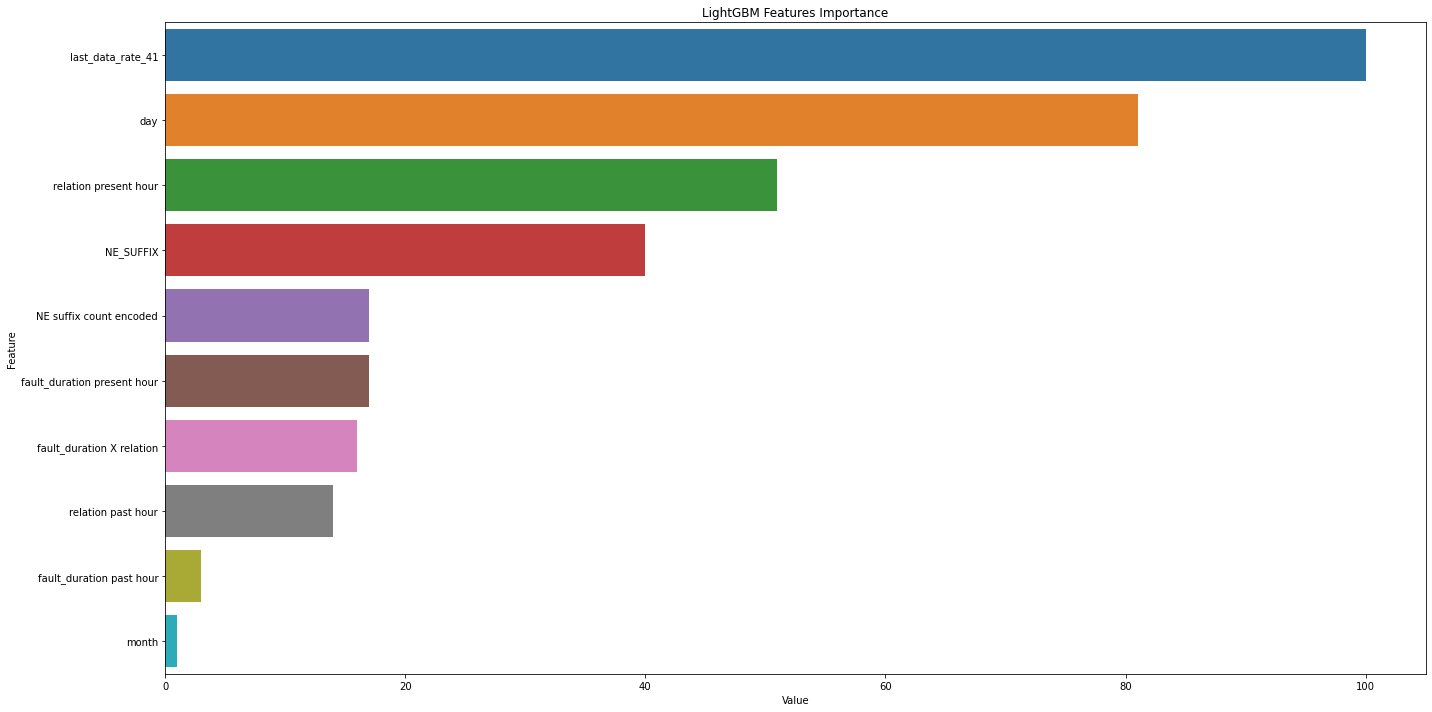

<Figure size 432x288 with 0 Axes>

In [141]:
# feature importance
feature_imp = pd.DataFrame(sorted(zip(model1.feature_importances_,cols)), columns=['Value','Feature']).head(10)
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')
plt.show()


- # Model 2 - Train Without Lag Features

In [142]:
cols=select_cols
tdf=tdf[tdf.count_available_features==len(cols)]
len(tdf), len(cols)

(131, 31)

In [143]:

model2 = LGBMClassifier(n_estimators=1000)
tdf["class"]=model2.fit(df[cols],df["class"]).predict_proba(tdf[cols])[:,1]
tdf["class"]= (tdf["class"]>0.4).astype("int")
x=tdf.copy()
label=ss.columns[1]
x[label]=x["class"]
pred2=x[ss.columns]
pred2[label]=pred2[label].astype("int")
pred2

<ipython-input-143-f81dbfb24bc0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred2[label]=pred2[label].astype("int")


,ID,data_rate_t+1_trend
5,B0017-25_25,0
155,B0017-32_12,1
173,B0017-32_14,1
176,B0017-32_15,0
187,B0017-32_17,0
...,...,...
127716,B0093-23_30,1
128085,B0093-25_27,0
128130,B0093-25_30,1
128246,B0093-25_39,0


In [144]:
# Append Predictions
pred=pred1.append(pred2)
pred=pred.drop_duplicates("ID",keep="last")
pred.to_csv('prediction.csv',index=False)
pred.describe()

,data_rate_t+1_trend
count,1932.000000
mean,0.699793
std,0.458467
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


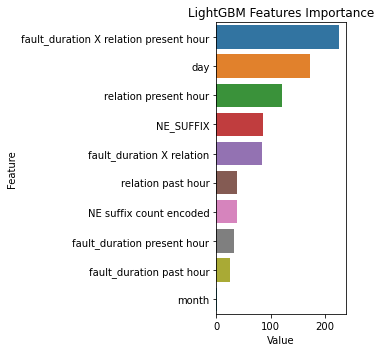

In [147]:
# feature importance
feature_imp = pd.DataFrame(sorted(zip(model2.feature_importances_,cols)), columns=['Value','Feature']).head(10)
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('lgbm_importances-02.png')
plt.show()
